In [ ]:
#connect to google drive
# change this to connect to cloud database when needed
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import librarys
import numpy as np
import xml.etree.ElementTree as ET
import os
import fnmatch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [ ]:
# don't run this part. This part is to test and find index of tags
# (find correct location of the data in xml)

#parse xml files
mytree = ET.parse('/content/drive/MyDrive/ECGproject/AF100/69045.xml')
myroot = mytree.getroot()

x=0
for child in myroot:
  print(x,child.tag)
  x = x+1
# extract the first label
for child in myroot[4][0]:
  print(child.text)
# extract I lead data:
x = 0
for child in myroot[11]:
  print(x, child.tag)
  x = x+1

x = 0
for child in myroot[11][5]:
  print(x,child.tag)
  x = x+1

#find the index for I, II and V1~V6
for x in range(5,17):
  print(x,myroot[11][x][6].text)

# check the index for I, II an V1~V6:
for x in list([5,6])+list(range(11,17)):
  print(x,myroot[11][x][6].text)

# according to the paper, only 8 indepent leads data are needed
# extract ecg data and store it into a numpy array with shape (5000,8)
data=[]
for x in list([5,6])+list(range(11,17)):
  data.append([int(i) for i in myroot[11][x][10].text.split()])
thisfiledata= np.array(data)
#tensorflow takes numpy.array

In [ ]:
# parse multiple XML files in the same folder
#(ones:diagnosedd as positive)
path = "/content/drive/MyDrive/ECGproject/AF100"

ECGlist = []
for filename in os.listdir(path):
  if fnmatch.fnmatch(filename, '*.xml'):
    with open(os.path.join(path, filename), "r") as data:
      tree = ET.parse(data)
      root = tree.getroot()
      data = []
      for x in list([5,6])+list(range(11,17)):
        data.append([int(i) for i in root[11][x][10].text.split()])
      dataT=np.array(data).T
      ECGlist.append(dataT)
ECGone = np.array(ECGlist)
print("ECGone shape :",ECGone.shape)

#print out the max, min and mean value

#for x in ["max", "min", "mean"]:
#  print("ECGone", x, ":",getattr(ECGone,x)())

ECGone shape : (100, 5000, 8)


In [ ]:
# parse multiple XML files in the same folder
# (zeros:diagnosed as negative)
path = "/content/drive/MyDrive/ECGproject/NM1000"

ECGlist = []
for filename in os.listdir(path):
  if fnmatch.fnmatch(filename, '*.xml'):
    with open(os.path.join(path, filename), "r") as data:
      tree = ET.parse(data)
      root = tree.getroot()
      data = []
      for x in list([5,6])+list(range(11,17)):
        data.append([int(i) for i in root[11][x][10].text.split()])
      dataT=np.array(data).T
      ECGlist.append(dataT)
ECGzeroTotal = np.array(ECGlist)
print("ECGzeroTotal shape :",ECGzeroTotal.shape)


#select 100 samples from normal cases randomly
ECGzero = ECGzeroTotal[np.random.choice(1000, 100),:, :]
print("ECGzero shape :",ECGzero.shape)

#print out the max, min and mean value
#for x in ["max", "min", "mean"]:
#  print("ECGzero", x, ":",getattr(ECGzero,x)())

ECGzeroTotal shape : (1000, 5000, 8)
ECGzero shape : (100, 5000, 8)


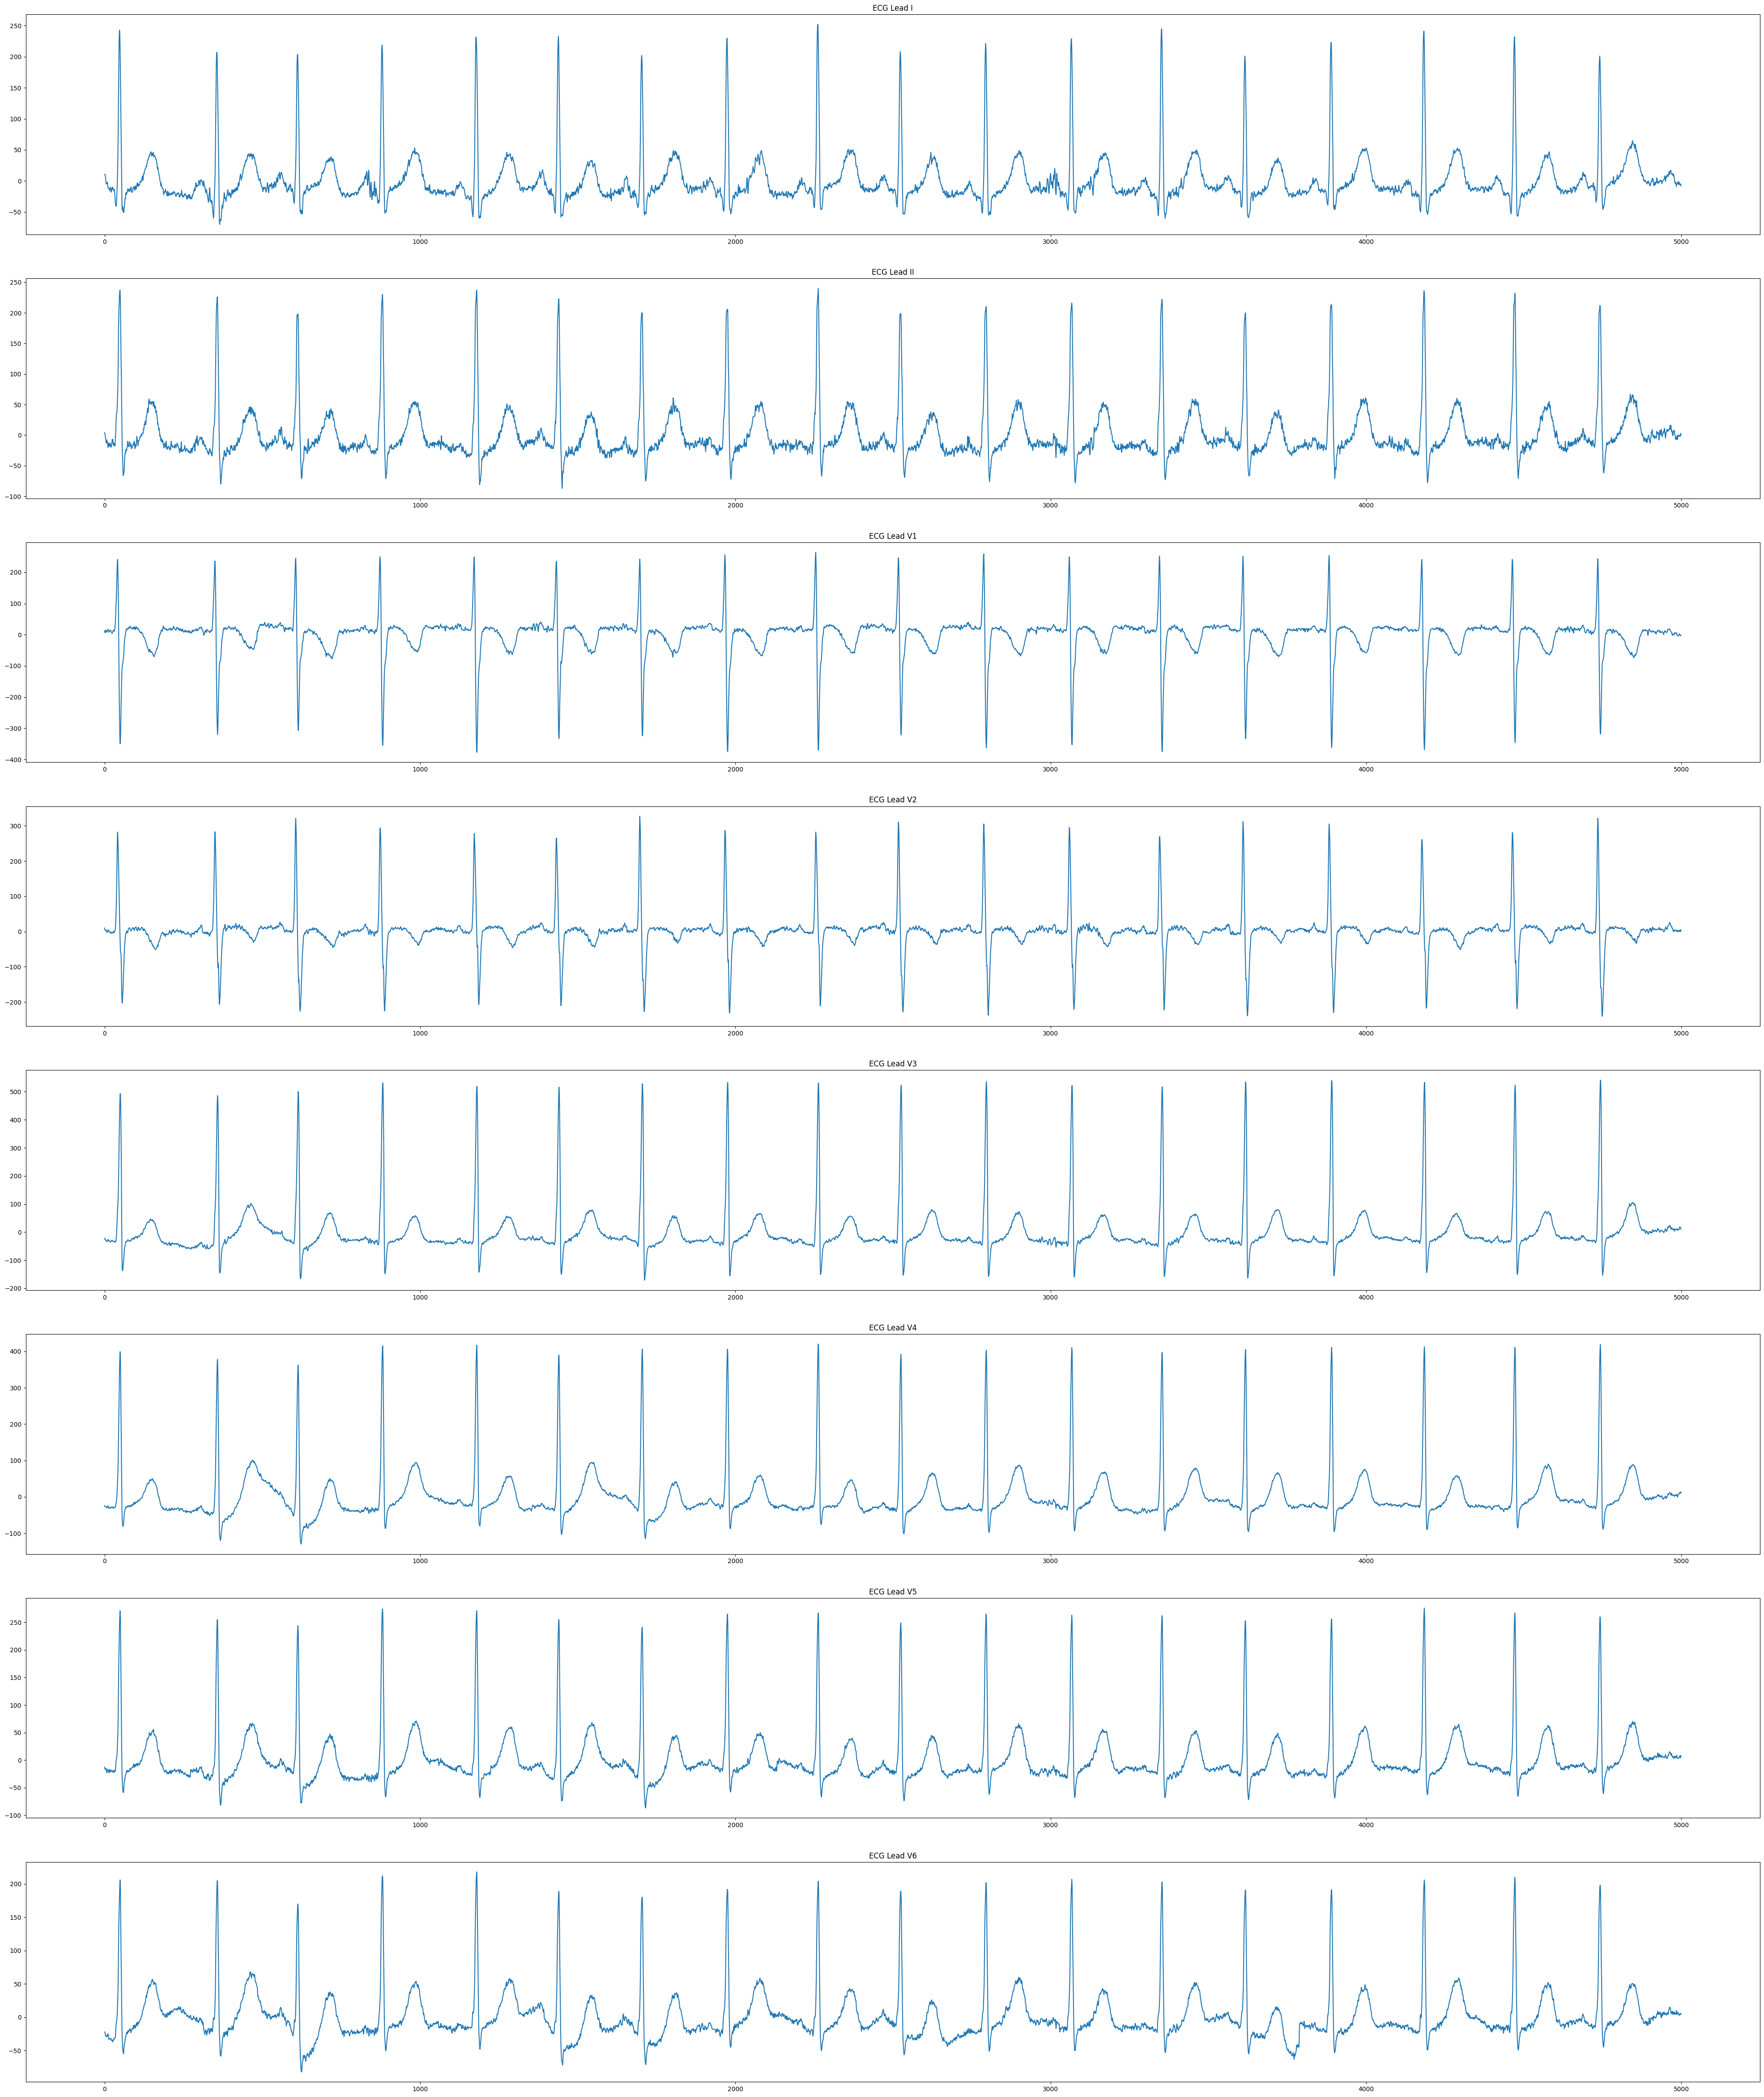

In [ ]:
# let's have a look of the data

data_inspect = ECGzero
#data_inspect = ECGone

patientIndex = np.random.choice(100)


# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(8,figsize=(50, 60))

# For Lead I
axis[0].plot(data_inspect[patientIndex, :, 0])
axis[0].set_title("ECG Lead I")

# For Lead II
axis[1].plot(data_inspect[patientIndex, :, 1])
axis[1].set_title("ECG Lead II")

# For Lead V1~V6
for i in np.arange(2,8):
  axis[i].plot(data_inspect[patientIndex, :, i])
  axis[i].set_title("ECG Lead V"+str(i-1))

# Combine all the operations and display
plt.show()


In [ ]:
# split the data into test, train and validation
#from sklearn.model_selection import train_test_split
# split the data into test data and the rest data
one_rest, one_test = train_test_split(ECGone, test_size=0.20, random_state=43)
zero_rest, zero_test = train_test_split(ECGzero, test_size=0.20, random_state=43)

# split the data into train data and the validation data
one_train, one_valid = train_test_split(one_rest, test_size=10, random_state=43)
zero_train, zero_valid = train_test_split(zero_rest, test_size=10, random_state=43)

# check the shape
print("one train size: ",one_train.shape)
print("one test size: ",one_test.shape)
print("one validation size: ",one_valid.shape)
print("zero train size: ",zero_train.shape)
print("zero test size: ",zero_test.shape)
print("zero validation size: ",zero_valid.shape)

one train size:  (70, 5000, 8)
one test size:  (20, 5000, 8)
one validation size:  (10, 5000, 8)
zero train size:  (70, 5000, 8)
zero test size:  (20, 5000, 8)
zero validation size:  (10, 5000, 8)


In [ ]:
# concatenate the ones and zeros
# to create the the combo of train, test and valid data
x_train_combo = np.concatenate((one_train,zero_train))
x_test_combo = np.concatenate((one_test,zero_test))
x_valid_combo = np.concatenate((one_valid,zero_valid))
# create y (labels for the data)
y_train = np.concatenate((np.ones(70), np.zeros(70)))
y_test= np.concatenate((np.ones(20),np.zeros(20)))
y_valid = np.concatenate((np.ones(10),np.zeros(10)))

In [ ]:
# zero padding
pad_train = np.zeros((140,60,8))
x_train_pad = np.concatenate((pad_train,x_train_combo,pad_train),axis =1)
pad_test = np.zeros((40,60,8))
x_test_pad = np.concatenate((pad_test,x_test_combo,pad_test),axis =1)
pad_valid = np.zeros((20,60,8))
x_valid_pad = np.concatenate((pad_valid, x_valid_combo, pad_valid), axis = 1)
print("training shape:",x_train_pad.shape)
print("testing shape:",x_test_pad.shape)
print("validation shape:",x_valid_pad.shape)

training shape: (140, 5120, 8)
testing shape: (40, 5120, 8)
validation shape: (20, 5120, 8)


In [ ]:
# Make sure images have shape (5120,8, 1) (for tensorflow keras to process)
x_train = np.expand_dims(x_train_pad, -1)
x_test = np.expand_dims(x_test_pad, -1)
x_valid = np.expand_dims(x_valid_pad, -1)
print("train input shape:",x_train.shape)
print("test input shape:",x_test.shape)
print("valid input shape:",x_valid.shape)


train input shape: (140, 5120, 8, 1)
test input shape: (40, 5120, 8, 1)
valid input shape: (20, 5120, 8, 1)


In [ ]:
# Define Resblock
def ResBlock(inputs,channelsize, K):

  #left arm
  x_left = layers.BatchNormalization()(inputs)
  x_left = layers.ReLU()(x_left)
  x_left = layers.Conv2D(filters = channelsize, kernel_size=(K,1))(x_left)
  x_left = layers.BatchNormalization()(x_left)
  x_left = layers.ReLU()(x_left)
  x_left = layers.Conv2D(filters = channelsize, kernel_size=(K,1),strides = (2,1))(x_left)

  # calculate the maxpooling pool size
  max_K = inputs.shape[1]-int((inputs.shape[1]-2*K+1)/2)*2
  #right arm
  x_right = layers.Conv2D(filters = channelsize, kernel_size=(1,1))(inputs)
  x_right = layers.MaxPooling2D(pool_size=(max_K,1),strides=(2, 1))(x_right)

  # sum up
  outputs = layers.Add()([x_left, x_right])
  return outputs


In [ ]:
# Model Arcitecture
inputs = keras.Input(shape=(5120,8,1))
#temporal axis pooling
block1 = ResBlock(inputs,16,7)
block2 = ResBlock(block1,16,7)
block3 = ResBlock(block2,16,7)
block3output = layers.Dropout(0.2)(block3)
block4 = ResBlock(block3output,32,5)
block5 = ResBlock(block4,32,5)
block6 = ResBlock(block5,32,5)
block6output = layers.Dropout(0.2)(block6)
block7 = ResBlock(block6,64,3)
block8 = ResBlock(block7,64,3)
block9 = ResBlock(block8,64,3)
block9output = layers.Dropout(0.2)(block9)

#lead axis pooling
x = layers.Conv2D(filters = 128, kernel_size=(1,8))(block9output)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)

#fully connection
x = layers.Flatten()(x)
outputs = layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="ECG_ResBlock")
model.summary()


Model: "ECG_ResBlock"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5120, 8, 1)]         0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 5120, 8, 1)           4         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 5120, 8, 1)           0         ['batch_normalization[0][0]'] 
                                                                                                  
 conv2d (Conv2D)             (None, 5114, 8, 16)          128       ['re_lu[0][0]']    

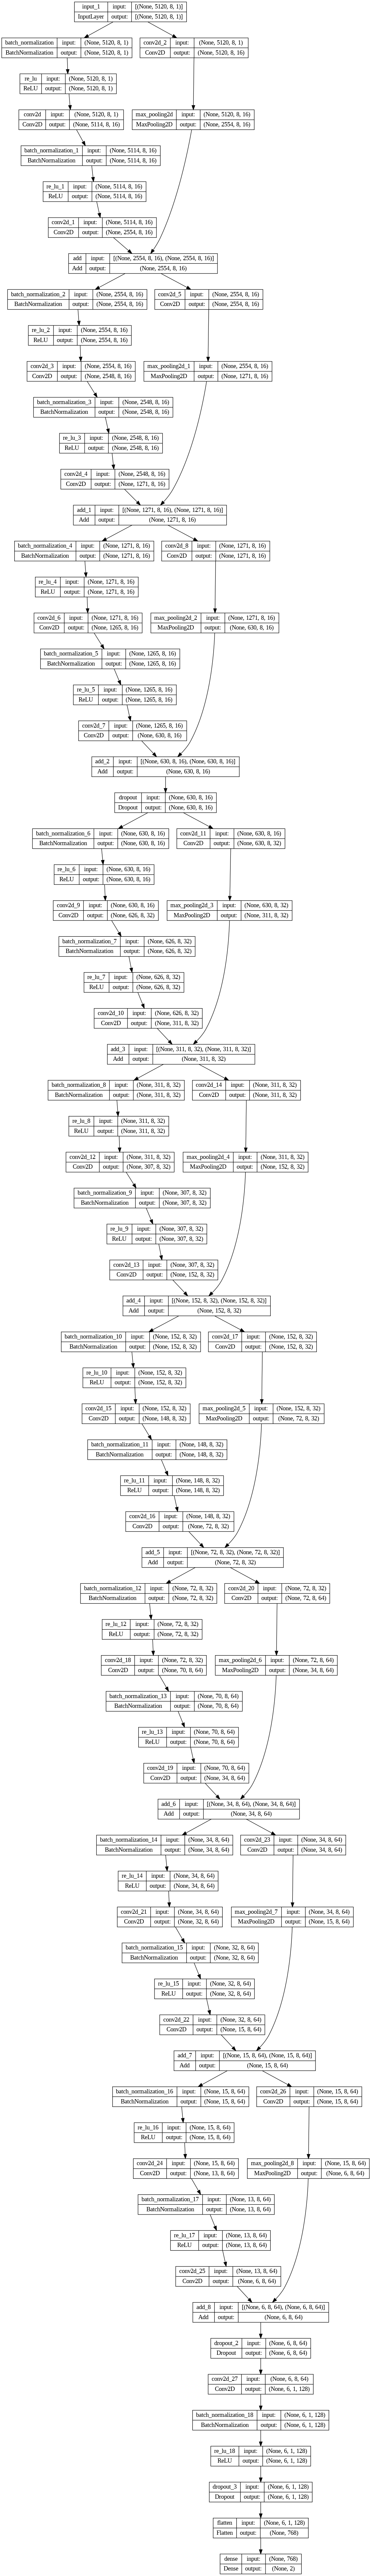

In [ ]:
keras.utils.plot_model(model, "model graph.png", show_shapes=True)

In [ ]:
# compile and fit the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)
history = model.fit(x_train, y_train, batch_size=16, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 [==============================] - 32s 3s/step - loss: 0.7387 - accuracy: 0.6786
Epoch 2/5
9/9 [==============================] - 23s 3s/step - loss: 0.4889 - accuracy: 0.8214
Epoch 3/5
9/9 [==============================] - 29s 3s/step - loss: 0.3177 - accuracy: 0.8571
Epoch 4/5
9/9 [==============================] - 24s 3s/step - loss: 0.2072 - accuracy: 0.9143
Epoch 5/5
9/9 [==============================] - 26s 3s/step - loss: 0.3432 - accuracy: 0.8857


In [ ]:
# evaluate the model using test data set, adjust the hyperparameters
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test accuracy:", test_scores[1])

2/2 - 2s - loss: 0.6303 - accuracy: 0.7750 - 2s/epoch - 1s/step
Test accuracy: 0.7749999761581421


In [ ]:
# evaluate the model using test data set, adjust the hyperparameters
valid_scores = model.evaluate(x_valid, y_valid, verbose=2)
print("Validadtion accuracy:", valid_scores[1])

1/1 - 1s - loss: 1.0715 - accuracy: 0.5500 - 793ms/epoch - 793ms/step
Validadtion accuracy: 0.550000011920929
